In [1]:
from spacy.lang.en import English
from time import perf_counter as timer
import json
import os
import re
import random
import torch
import numpy as np
import pandas as pd
import textwrap
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import networkx as nx
from pyvis.network import Network
from IPython.display import display, HTML
import ast
from itertools import combinations
import community

In [2]:
variables = pd.read_csv("../program2/variables.csv")
TOPK = 10

config_params = ast.literal_eval(variables.iloc[0,0])

# RAG

In [3]:
rows_dict = {}
with open("config.txt", "r") as file:
    for i, line in enumerate(file):
        rows_dict[f"row_{i+1}"] = line.strip()
#for key, value in rows_dict.items():
#    print(f"{key}: {value}")
llms_conf = rows_dict["row_1"]
llms_conf = json.loads(llms_conf)
prompts_conf = rows_dict["row_2"]
prompts_conf = json.loads(prompts_conf)
embeddings_conf = rows_dict["row_3"]
embeddings_conf = json.loads(embeddings_conf)
temp_conf = rows_dict["row_4"]
temp_conf = json.loads(temp_conf)

In [4]:
embedding_model = SentenceTransformer(model_name_or_path=embeddings_conf[config_params[2]], trust_remote_code=True, device="cuda")

In [5]:
import ast
import numpy.core.multiarray
df = pd.read_pickle("embeddings_" + str(config_params[2]) + ".pkl")
device = "cuda" if torch.cuda.is_available() else "cpu"
pages_and_chunks = df.to_dict(orient="records")
embeddings = torch.tensor(np.array(df["Embedding"].tolist()), dtype=torch.float32).to(device)
#embeddings.shape

In [6]:
llm_model = AutoModelForCausalLM.from_pretrained(llms_conf[config_params[0]],
                                         torch_dtype=torch.float16,
                                         low_cpu_mem_usage=True)
llm_model.to(device)
tokenizer = AutoTokenizer.from_pretrained(llms_conf[config_params[0]])
tokenizer.pad_token_id=tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    context = "- " + "\n- ".join([item["Abstract"] for item in context_items])
    base_prompt = prompts_conf[config_params[1]][0]
    #print(base_prompt)
    base_prompt = base_prompt.format(context=context, query=query)
    #print(base_prompt)
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [8]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=TOPK,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """
    query_embedding = model.encode(query, convert_to_tensor=True)
    start_time = timer()
    if config_params[2]==0:
        dot_scores = util.dot_score(query_embedding, embeddings)[0]
    else:
        dot_scores = util.cos_sim(query_embedding, embeddings)[0]
    end_time = timer()
    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")
    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)
    return scores, indices

In [9]:
def ask(query,
        temperature=temp_conf[config_params[3]],
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
    context_items = [pages_and_chunks[i] for i in indices]
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()
    prompt = prompt_formatter(query=query, context_items=context_items)
    input_ids = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 max_new_tokens=max_new_tokens,
                                 do_sample=True)
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")
    if return_answer_only:
        return output_text

    return output_text, context_items

In [10]:
def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [11]:
#query = "What are tailings, and what are the challenges associated with their management in the mineral processing industry?"
query = "What are tailings, and how do environmental, chemical, and geotechnical factors influence sustainable tailings management in mineral processing operations?"
print(f"Query: {query}")
answer, context_items = ask(query, return_answer_only=False)
#print(f"Answer:\n")
#print_wrapped(answer)
#print(f"Context items:")
#context_items

Query: What are tailings, and how do environmental, chemical, and geotechnical factors influence sustainable tailings management in mineral processing operations?
[INFO] Time taken to get scores on 9164 embeddings: 0.00146 seconds.


# Knowledge Graph

In [12]:
print(f"Number of texts extracted: {len(context_items)}")

Number of texts extracted: 10


In [13]:
# Define a cosine similarity function optimized for PyTorch tensors
def cosine_similarity_pytorch(matrix):
    """
    Computes pairwise cosine similarity for a given matrix of vectors.

    Args:
        matrix (torch.Tensor): A 2D tensor where each row is a vector.

    Returns:
        torch.Tensor: A 2D tensor containing cosine similarity scores.
    """
    # Compute the dot product of each vector with all others
    dot_products = torch.mm(matrix, matrix.T)
    # Compute the L2 norm for each vector
    norms = torch.norm(matrix, dim=1, keepdim=True)
    # Compute the outer product of norms
    norm_products = torch.mm(norms, norms.T)
    # Return cosine similarity scores
    return dot_products / norm_products

pd.options.display.float_format = '{:.6f}'.format  # Display values with six decimal places

# Step 1: Extract abstracts from the provided list
abstracts_from_list = [item['Abstract'] for item in context_items]

# Initialize the TF-IDF vectorizer
#vectorizer = TfidfVectorizer()
#similar_abstracts = []

"""
for idx, list_abstract in enumerate(abstracts_from_list):
    # Crear un corpus con el abstract actual y los del DataFrame
    corpus = [list_abstract] + df['Abstract'].tolist()

    # Transformar el corpus en una matriz TF-IDF dispersa
    tfidf_matrix = vectorizer.fit_transform(corpus)

    # Mantener la matriz como dispersa
    tfidf_tensor_sparse = torch.tensor(tfidf_matrix.toarray(), dtype=torch.float32)

    # Normalizar los vectores
    norms = torch.norm(tfidf_tensor_sparse, dim=1, keepdim=True)
    normalized_tensors = tfidf_tensor_sparse / norms

    # Calcular similitudes coseno usando matrices densas en la CPU
    similarity_matrix = torch.mm(normalized_tensors, normalized_tensors.T)

    # Extraer similitudes para el vector base
    base_similarities = similarity_matrix[0, 1:]
    similar_indices = torch.where(base_similarities > 0.95)[0]

    for i in similar_indices.numpy():
        similar_abstracts.append({
            "Title": f"Text{idx + 1}",
            "Abstract": df.iloc[i]['Abstract'],
            "Similarity": base_similarities[i].item()
        })
"""


# Convert the results to a DataFrame
result_df = pd.DataFrame(abstracts_from_list).rename(columns={0: "Abstract"})
result_df["Title"] = pd.Index(range(TOPK))
result_df = result_df[["Title", "Abstract"]]

# Display the results
#result_df

In [14]:
if (config_params[0] == 0) :
    # Usar una expresión regular para extraer el contenido entre las etiquetas
    #match = re.search(r"<\|begin_of_text\|>(.*?)<\|eot_id\|>", answer, re.DOTALL)
    new_text = answer.replace("<|begin_of_text|>", "").strip()
    new_text = answer.replace("<|im_end|>", "").strip()
    #print(match)
    #if match:
    #    new_text = match.group(1).strip()
    #    #print(new_text)
    #else:
    #    new_text = ""
    #    print("No se encontró texto entre las etiquetas.")

elif (config_params[0] == 1) :
    new_text = answer.replace("<|im_end|>", "").strip()

elif (config_params[0] == 2) :
    new_text = answer.strip()

elif (config_params[0] == 3) :
    new_text = answer.replace("<|im_end|>", "").strip()

else:
    new_text = ""

new_title = 11

In [15]:
# Download necessary NLTK resources
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Preprocessing: considers the whole text as one block, ignores sentence boundaries
def preprocess(text):
    text = text.lower()  # Convert to lowercase

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the whole text into words
    tokens = word_tokenize(text)

    # Remove stopwords
    filtered_tokens = [w for w in tokens if w not in stop_words]
    
    return filtered_tokens  # Return a flat list of filtered tokens

# Build co-occurrence graph for the whole text (no sentence boundary)
def build_cooccurrence_network(tokens, window_size=3):
    G = nx.Graph()
    
    # Slide window and create edges for each token pair
    for i in range(len(tokens) - window_size + 1):
        window = tokens[i:i + window_size]
        for w1, w2 in combinations(window, 2):
            if G.has_edge(w1, w2):
                G[w1][w2]['weight'] += 1
            else:
                G.add_edge(w1, w2, weight=1)
    return G

# Process abstracts from the DataFrame
networks = []
for abstract in result_df["Abstract"]:
    tokens = preprocess(abstract)
    G = build_cooccurrence_network(tokens)
    networks.append(G)

# Process additional text
tokens_extra = preprocess(new_text)
G_extra = build_cooccurrence_network(tokens_extra)

[nltk_data] Downloading package stopwords to /home/jupyter-
[nltk_data]     lucay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def Natural_connectivity(graph):#https://arxiv.org/pdf/2105.00419    http://dx.doi.org/10.1016/j.physa.2017.01.0720
    L  = nx.adjacency_spectrum(graph)
    L1 = sum(np.exp(np.real(L[i])) for i in range(graph.number_of_nodes()))
    return np.log(L1/graph.number_of_nodes())/(graph.number_of_nodes() - np.log(graph.number_of_nodes()))

def Conductance(graph): #hhttp://dx.doi.org/10.1016/j.physa.2017.01.072
    L     = nx.laplacian_matrix(graph)
    eig   = np.round(np.linalg.eigvals(L.toarray()),5)
    N     = graph.number_of_nodes()
    S     = 0
    for i in range(len(eig)):
        if np.real(eig[i])!=0:
            S = S + 1/np.real(eig[i])
    return (N-1)/(N*S)

def SpectralRadius(G):# doi:10.1016/j.disc.2019.05.017
    n = G.number_of_nodes()
    m = G.number_of_edges()
    if n <= 1:
        return 0.0
    A    = nx.adjacency_matrix(G).toarray()
    eig  = np.linalg.eigvalsh(A)
    spec = np.max(np.abs(eig))
    k = None
    for pot_k in range(3, n + 1):
        lb = (pot_k - 2) * (pot_k - 3) / 2
        ub = pot_k * (pot_k - 3) / 2
        if lb <= m - n <= ub:
            k = pot_k
            break
    if k is None:
        return spec / (n - 1)
    t1 = 2 * m - n - k + 2.5
    t2 = np.sqrt(2 * m - 2 * n + 2.25)
    upper_bound = np.sqrt(t1 + t2)
    normalized_radius = spec / upper_bound if upper_bound != 0 else 0.0
    return normalized_radius

# Revisar
def SpectralGap(graph):
    L     = nx.normalized_laplacian_matrix(graph).toarray()
    eig   = np.linalg.eigvalsh(L)
    eig.sort()
    return np.real(eig[1])/2

def AverageDegree(graph):
    N = nx.number_of_nodes(graph.copy())
    return (sum(dict(graph.degree()).values())/N)/(N-1)

def AverageEdgeBetweenness(graph): #vulnerability of complex networks Igor mishkovski
    N  = nx.number_of_nodes(graph.copy())
    return (1/nx.average_shortest_path_length(graph) - 1)/(6/(N*(N+1)) - 1)

def calculate_modularity(graph):
    partition = community.best_partition(graph)
    modularity = community.modularity(partition, graph)
    return modularity

def calculate_metrics(graph):
    metrics = {}
    metrics['Connected Components'] = nx.number_connected_components(graph)
    if not nx.is_connected(graph):
        graph = graph.subgraph(max(nx.connected_components(graph), key=len)).copy()
    # Connectivity
    metrics['Global Efficiency'] = nx.global_efficiency(graph) # max
    metrics['Average Edge Betweenness'] = AverageEdgeBetweenness(graph)# max
    # Adjacency Matrix Spectrum
    metrics['Spectral Radius'] = SpectralRadius(graph) # max
    metrics['Spectral Gap'] = SpectralGap(graph) # max
    metrics['Natural Connectivity'] = Natural_connectivity(graph) # max
    # Laplacian Matrix Spectrum
    metrics['Algebra Connectivity'] = nx.algebraic_connectivity(graph)/graph.number_of_nodes() #max
    metrics['Conductance'] = Conductance(graph) # max

    # Null Model
    nullModel = nx.Graph(nx.configuration_model([deg for node, deg in graph.degree()]))
    metrics['G Modularity'] = calculate_modularity(graph)
    metrics['Null Model Modularity'] = calculate_modularity(nullModel)
    return metrics

In [17]:
# Function to plot the interactive graph and save it as an HTML file
def plot_interactive_graph_colab(graph, filename="graph.html"):
    # Compute node positions using NetworkX
    pos = nx.spring_layout(graph)  # You can replace this with another layout like nx.circular_layout(graph)

    # Create PyVis graph
    net = Network(height="750px", width="100%", bgcolor="#ffffff", font_color="black", cdn_resources="in_line")

    # Add nodes with precomputed positions
    for node, data in graph.nodes(data=True):
        x, y = pos[node]  # Get the position of the node
        net.add_node(
            node,
            title=f"Word: {node}",
            color=data.get('color', 'blue'),  # Default to blue if no color is specified
            x=x * 1000,  # Scale positions for PyVis
            y=y * 1000,
            label=""  # Hide labels if desired
        )

    # Add edges
    for source, target in graph.edges():
        net.add_edge(source, target)

    # Disable physics
    net.set_options("""
    {
        "physics": {
            "enabled": false
        }
    }
    """)

    filename = f"Graphs/{filename}"

    # Save the HTML file
    net.save_graph(filename)

    # Display the graph directly in the notebook or environment
    with open(filename, "r") as f:
        display(HTML(f.read()))

In [18]:
metrics_list = []

# Display the graphs of the 10 abstracts and calculate metrics
for idx, (title, graph) in enumerate(zip(result_df["Title"], networks)):
    # Create a valid filename (without special characters)
    safe_title = "".join(c if c.isalnum() else "_" for c in str(title))
    filename = f"Abstract_{idx+1}_{safe_title}.html"

    # Display and save graph
    # plot_interactive_graph_colab(graph, filename)

    # Calculate metrics
    try:
        m = calculate_metrics(graph)
        m["Title"] = title
        m['config'] = config_params
        m['i'] = variables.iloc[0,1]
    except Exception as e:
        print("Error 1")
        m = {"Title": title, "Error": str(e)}
    metrics_list.append(m)

# Graph and metrics for the additional abstract
# plot_interactive_graph_colab(G_extra, "New_Text_Extra.html")

try:
    m_extra = calculate_metrics(G_extra)
    m_extra["Title"] = "Proposed"
    m_extra['config'] = config_params
    m_extra['i'] = variables.iloc[0,1]
except Exception as e:
    print("Error 2")
    m_extra = {"Title": "Proposed", "Error": str(e)}

In [19]:
# Create DataFrame with all metrics
metrics_df = pd.DataFrame(metrics_list)
# metrics_df

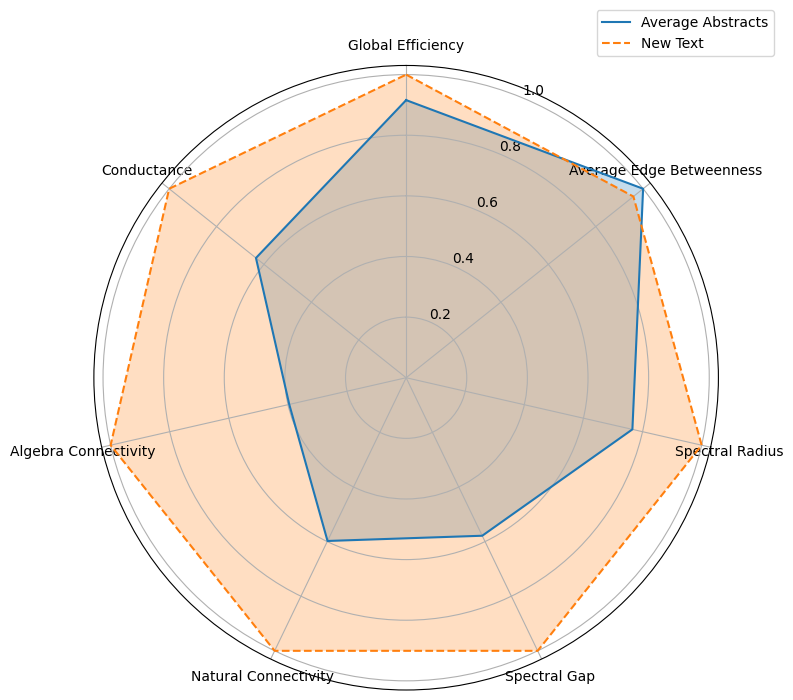

Area Before: 1.3829867859279021
Area After: 2.704319615852733


In [20]:
# Filter valid metrics (exclude errors and null values)
valid_metrics_df = metrics_df.dropna(subset=[
    col for col in metrics_df.columns 
    if col not in ["Title", "Error"]
])

# Compute the average of each metric, excluding the 'Title' column
average_metrics = valid_metrics_df.drop(columns=["Title", "config", "i", "Connected Components", "G Modularity", "Null Model Modularity"]).mean()

# Convert the m_extra dictionary to a Series to ensure consistent ordering
m_extra_series = pd.Series({k: v for k, v in m_extra.items() if k in average_metrics.index})

# Reorder m_extra_series to match average_metrics
m_extra_series = m_extra_series[average_metrics.index]

# Normalize each metric
normalized_avg = []
normalized_extra = []

for metric in average_metrics.index:
    avg_val = average_metrics[metric]
    extra_val = m_extra_series[metric]
    max_val = max(avg_val, extra_val)

    if max_val > 0:
        normalized_avg.append(avg_val / max_val)
        normalized_extra.append(extra_val / max_val)
    else:
        normalized_avg.append(0)
        normalized_extra.append(0)

# Close the polygon
normalized_avg += normalized_avg[:1]
normalized_extra += normalized_extra[:1]
angles = np.linspace(0, 2 * np.pi, len(average_metrics) + 1, endpoint=True)

# Create radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, normalized_avg, label='Average Abstracts', linestyle='solid')
ax.fill(angles, normalized_avg, alpha=0.25)

ax.plot(angles, normalized_extra, label='New Text', linestyle='dashed')
ax.fill(angles, normalized_extra, alpha=0.25)

# Labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), list(average_metrics.index))

ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()

plt.savefig(f"../program2/Resultados_mejores/Graphs/radar_chart_{config_params}_{variables.iloc[0,1]}.png", dpi=300)

plt.show()


def calculate_radar_area(values, angles):
    n = len(values)
    area = 0.5 * np.abs(
        sum(values[i] * values[i + 1] * np.sin(angles[i + 1] - angles[i]) for i in range(n - 1))
    )
    return area

# Area calculation
area_avg = calculate_radar_area(normalized_avg, angles)
area_new = calculate_radar_area(normalized_extra, angles)

print("Area Before:", area_avg)
print("Area After:", area_new)

# Result

In [21]:
file_path = "../program2/Resultados_mejores/resultadoExperimentoGraph.csv"

In [22]:
result = pd.DataFrame([{
    'config' : config_params,
    'i' : variables.iloc[0,1],
    'n_abstracts' : abstracts_from_list,
    'proposed' : new_text,
    'metrics_avg' : average_metrics.to_list(),
    'metrics_new' : m_extra_series.to_list(),
    'delta_metrics' : (m_extra_series - average_metrics).to_list(),
    'area_avg' : area_avg,
    'area_new' : area_new
}])
#result

In [23]:
if os.path.exists(file_path):
    bd = pd.read_csv(file_path)
    bd = pd.concat([bd, result], ignore_index=True)
else:
    bd = result  # Si no existe, creamos un nuevo DataFrame con los datos

# Guardar el DataFrame en un archivo CSV
bd.to_csv(file_path, index=False)

In [24]:
# Crear DataFrame con número de nodos y aristas por grafo
graph_stats = []
for idx, (title, graph) in enumerate(zip(result_df["Title"], networks)):
    graph_stats.append({
        "config": config_params,
        "i": variables.iloc[0,1],
        "Title": title,
        "Num_Nodes": graph.number_of_nodes(),
        "Num_Edges": graph.number_of_edges()
    })

graph_stats.append({
        "config": config_params,
        "i": variables.iloc[0,1],
        "Title": "Proposed",
        "Num_Nodes": G_extra.number_of_nodes(),
        "Num_Edges": G_extra.number_of_edges()
    })
graph_stats_df = pd.DataFrame(graph_stats)

# Crear DataFrame con el degree de cada palabra por grafo
degree_data = []
for idx, (title, graph) in enumerate(zip(result_df["Title"], networks)):
    for node, degree in graph.degree():
        degree_data.append({
            "config": config_params,
            "i": variables.iloc[0,1],
            "Title": title,
            "Word": node,
            "Degree": degree
        })

for node, degree in G_extra.degree():
    degree_data.append({
        "config": config_params,
        "i": variables.iloc[0,1],
        "Title": "Proposed",
        "Word": node,
        "Degree": degree
    })

degree_df = pd.DataFrame(degree_data)

# Generar una lista de DataFrames con las matrices de adyacencia
adjacency_matrices = {}
for idx, (title, graph) in enumerate(zip(result_df["Title"], networks)):
    matrix = nx.to_pandas_adjacency(graph, dtype=int)
    adjacency_matrices[title] = matrix  # guardar usando el título como clave

matrix = nx.to_pandas_adjacency(G_extra, dtype=int)
adjacency_matrices["Proposed"] = matrix  # guardar usando el título como clave

# Mostrar resultados
#graph_stats_df

In [25]:
file_path = "../program2/Resultados_mejores/ExtraData/resultadoGraphStatsGraph.csv"
if os.path.exists(file_path):
    bd = pd.read_csv(file_path)
    bd = pd.concat([bd, graph_stats_df], ignore_index=True)
else:
    bd = graph_stats_df  # Si no existe, creamos un nuevo DataFrame con los datos

# Guardar el DataFrame en un archivo CSV
bd.to_csv(file_path, index=False)

In [26]:
#degree_df[degree_df["Title"] == 0].sort_values("Degree", ascending=False)

In [27]:
file_path = "../program2/Resultados_mejores/ExtraData/resultadoGraphDegreeGraph.csv"
if os.path.exists(file_path):
    bd = pd.read_csv(file_path)
    bd = pd.concat([bd, degree_df], ignore_index=True)
else:
    bd = degree_df  # Si no existe, creamos un nuevo DataFrame con los datos

# Guardar el DataFrame en un archivo CSV
bd.to_csv(file_path, index=False)

In [28]:
#adjacency_matrices["Proposed"]

In [29]:
adjacency_data = []

for title, matrix in adjacency_matrices.items():
    stacked = matrix.stack().reset_index()
    stacked.columns = ['source', 'target', 'value']
    for _, row in stacked.iterrows():
        adjacency_data.append({
            "config": config_params,
            "i": variables.iloc[0, 1],
            "Title": title,
            "source": row['source'],
            "target": row['target'],
            "value": row['value']
        })

adjacency_df = pd.DataFrame(adjacency_data)

adjacency_df = adjacency_df[adjacency_df["value"] != 0].reset_index(drop=True)

file_path = "../program2/ExtraData/resultadoAdjacencyMatrixGraph.csv"
if os.path.exists(file_path):
    bd = pd.read_csv(file_path)
    bd = pd.concat([bd, adjacency_df], ignore_index=True)
else:
    bd = adjacency_df  # Si no existe, creamos un nuevo DataFrame con los datos

# Guardar el DataFrame en un archivo CSV
bd.to_csv(file_path, index=False)

In [30]:
metrics_list.append(m_extra)
# Create DataFrame with all metrics
metrics_df = pd.DataFrame(metrics_list)
#metrics_df

In [31]:
file_path = "../program2/Resultados_mejores/ExtraData/resultadoMetricsGraph.csv"
if os.path.exists(file_path):
    bd = pd.read_csv(file_path)
    bd = pd.concat([bd, metrics_df], ignore_index=True)
else:
    bd = metrics_df  # Si no existe, creamos un nuevo DataFrame con los datos

# Guardar el DataFrame en un archivo CSV
bd.to_csv(file_path, index=False)